In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nf
from netCDF4 import Dataset
import glob,os
%matplotlib inline

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

In [2]:
datapath="/work/FAC/FGSE/IDYST/tbeucler/default/saranya/Data/ECMWF/ERA5_25kmx3hr/"
path="/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/besttracks/"
target="/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/create_ts/outputs/targets/"

ds0=xr.open_dataset(datapath+'prate/totprec_2001_2010.nc')


In [151]:
track = sorted(glob.glob(path+'*2010*.csv'))

In [152]:
track

['/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/besttracks/2010_wp_storms.csv']

In [153]:
tracksDF = pd.read_csv(track[0])
stormname = tracksDF['name'].unique()

In [154]:
stormname

array(['OMAIS', 'CONSON', 'CHANTHU', 'DIANMU', 'LIONROCK', 'KOMPASU',
       'MALOU', 'MERANTI', 'FANAPI', 'MALAKAS', 'MEGI', 'CHABA', 'OMEKA'],
      dtype=object)

In [81]:
##########function############
def output_indices(TCtrack=None,ERA5date=None,ERA5hour=None):
    allindices = []
    for timeidx in range(len(TCtrack)):#len(track['time'])):
        datetrack,hourtrack = TCtrack['time'][timeidx].split(':')[0],TCtrack['time'][timeidx].split(':')[1][0:2]
        ####################################################################################################
        # Find the indices in ERA5 data with the same date as track
        ####################################################################################################
        dateind = []
        for ind,obj in enumerate(ERA5date):
            if obj==datetrack:
                dateind.append(ind)
        del ind,obj
        hourind = []
        hourextract = ERA5hour[int(np.min(np.asarray(dateind))):int(np.max(np.asarray(dateind)))+1]
        for ind,obj in enumerate(hourextract):
            if obj==hourtrack:            
                hourind.append(ind)
        allindices.append((int(np.min(np.asarray(dateind))),int(hourind[0])))
    return allindices

def extract_var(dataset=None,var='var138',indices=None):
    extractedvar = []
    for i in (range(len(indices))):
        realindex = indices[i][0]+indices[i][1]
        extractedvar.append(dataset[var][int(realindex),...].data)
    return np.asarray(extractedvar)

def extract_varnotransform(dataset=None,var='var138',indices=None):
    extractedvar = []
    for i in (range(len(indices))):
        realindex = indices[i][0]+indices[i][1]
        extractedvar.append(dataset[var][int(realindex),...])
    return (extractedvar)

def smallarea(dataset=None,invar=None,indices=None,tc_irad=None):
    if len(invar.shape) != 3:
        invar = np.squeeze(invar)
    ds = xr.Dataset(
    data_vars=dict(variable=(["time","lat","lon"], invar)),#mysvar[0])),
    coords=dict(lat=(["lat"], dataset.lat.data),lon=(["lon"], dataset.lon.data),time=(["time"], np.linspace(0,len(indices)-1,len(indices)))),
    attrs=dict(description="coords with matrices"),)
    
    LATN,LATS,LONE,LONW = tc_irad[0,:]
    testsmall = ds['variable'][0,:,:].sel(lat=slice(LATS,LATN),lon=slice(LONE,LONW))
    if testsmall.shape[0]<testsmall.shape[1]:
        rgspt = int(testsmall.shape[0])
    else:
        rgspt = int(testsmall.shape[1])
    rgspt=16
    var_out=np.zeros((len(indices),rgspt,rgspt))
    del testsmall
    
    for it in range(len(indices)):
        latn, lats, lone, lonw = tc_irad[it,:]
        try:
            var_out[it,:,:]=ds['variable'][it,:,:].sel(lat=slice(lats,latn),lon=slice(lone,lonw))
        except:
            var_out[it,:,:]=ds['variable'][it,:,:].sel(lat=slice(lats,latn),lon=slice(lone,lonw))[0:rgspt,0:rgspt]
    return var_out

def largearea_withpres(dataset=None,invar=None,indices=None,tc_irad=None,rgspthard=16):
    ds = xr.Dataset(
    data_vars=dict(variable=(["time","plev","lat","lon"], invar)),#mysvar[0])),
    coords=dict(lat=(["lat"], dataset.lat.data),lon=(["lon"], dataset.lon.data),time=(["time"], np.linspace(0,len(indices)-1,len(indices))),
               plev=(["plev"],dataset.plev.data)),
    attrs=dict(description="coords with matrices"),)
    
    LATN,LATS,LONE,LONW = tc_irad[0,:]
    testsmall = ds['variable'][0,0,:,:].sel(lat=slice(LATS,LATN),lon=slice(LONE,LONW))
    if testsmall.shape[0]<testsmall.shape[1]:
        rgspt = int(testsmall.shape[0])
    else:
        rgspt = int(testsmall.shape[1])
    rgspt=rgspthard
    var_out=np.zeros((len(indices),len(dataset.plev.data),rgspt,rgspt))
    del testsmall
    
    for it in range(len(indices)):
        latn, lats, lone, lonw = tc_irad[it,:]
        for ip in range(len(dm1.plev.data)):
            try:
                var_out[it,ip,:,:]=ds['variable'][it,ip,:,:].sel(lat=slice(lats,latn),lon=slice(lone,lonw))
            except:
                var_out[it,ip,:,:]=ds['variable'][it,ip,:,:].sel(lat=slice(lats,latn),lon=slice(lone,lonw))[0:rgspt,0:rgspt]
    return var_out

In [155]:
def readyear_automatic(raindata=None,year=None):
    dm2 = xr.open_dataset(datapath+'/slev_vars/svars_'+str(year)+'.nc')
    #tracklist = sorted(glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/besttracks/nio/*_'+str(year)+'*'))
    era5_date = [str(dm2.time[i].data).split('T')[0] for i in range(len(dm2.time))]
    era5_hour = [str(dm2.time[i].data).split('T')[1][0:2] for i in range(len(dm2.time))]
    
    era5_raindate = [str(raindata.time[i].data).split('T')[0] for i in range(len(raindata.time))]
    era5_rainhour = [str(raindata.time[i].data).split('T')[1][0:2] for i in range(len(raindata.time))]
    return dm2,era5_date,era5_hour,era5_raindate,era5_rainhour

dm_svar,svar_date,svar_hour,rain_date,rain_hour = readyear_automatic(ds0,2010)

In [137]:
#for dm1 files functions
def make_timeseries_step1(TCname=None,era5_date=None,era5_hour=None):
    track=tracksDF[tracksDF['name']==TCname].reset_index()
    lon1=track['lon'].to_numpy()
    lat1=track['lat'].to_numpy()
    pos = np.stack((lat1, lon1), axis=1)
    ###########################################################################
    indices_store = output_indices(track,era5_date,era5_hour)
    ###########################################################################
    tc_irad=np.empty((len(indices_store),4))
    tc_irad[:,0] = pos[:,0]-5
    tc_irad[:,1] = pos[:,0]+5
    tc_irad[:,2] = pos[:,1]-5
    tc_irad[:,3] = pos[:,1]+5
    return pos,indices_store,tc_irad

def make_timeseries_step3(dm1=None,pvarname=None,pvardict=None,indices_store=None):
    ts_pdict = {}
    for ind,obj in (enumerate(pvarname)):
        pvarTS_store = []
        for plevv in range(len(dm1.plev.data)):
            tempvar = pvardict[pvarname[ind]][:,plevv,...]
            tempts = [tempvar[i,...].flatten() for i in range(len(indices_store))]
            tempTSERIES = [np.nanmean(obj) for obj in tempts]
            pvarTS_store.append(tempTSERIES)
        ts_pdict[pvarname[ind]] = np.asarray(pvarTS_store).transpose()
    return ts_pdict

def preproc_integration(array_precip=None,array_cloud=None,cloudmaskvalue=None):
    pprm = array_precip.copy().flatten()
    pprm[array_cloud.copy().flatten()<cloudmaskvalue] = 0
    return pprm.reshape(array_precip.shape)

In [156]:
#precipitation target
from tqdm import tqdm
TCprecip_ts = []
for TCname in tqdm(stormname):
    ###########################################################################
    pos,indices_store,tc_irad = make_timeseries_step1(TCname=TCname,era5_date=svar_date,era5_hour=svar_hour)
    _,rainindices_store,_ = make_timeseries_step1(TCname=TCname,era5_date=rain_date,era5_hour=rain_hour)
    
    svar0 = extract_varnotransform(dataset=dm_svar,var='var79',indices=indices_store)
    svar1 = extract_varnotransform(dataset=dm_svar,var='var78',indices=indices_store)
    clouds = svar0+svar1
    
    precip = extract_varnotransform(dataset=ds0,var='var228',indices=rainindices_store)
    
    ppr=np.zeros((pos.shape[0],40,40))
    pp=np.zeros((tc_irad.shape[0],))
    ppm=np.zeros((tc_irad.shape[0],))
    ppmaskcloud = np.zeros((pos.shape[0],40,40))
    for it in range(tc_irad.shape[0]):
        #precip_nan=precip.where(precip>0, other='nan')
        latn, lats, lone, lonw = tc_irad[it,:]
        ppr[it,:,:]=precip[it].sel(lat=slice(lats,latn),lon=slice(lone,lonw))[0:40,0:40]
        ppmaskcloud[it,:,:]=clouds[it].sel(lat=slice(lats,latn),lon=slice(lone,lonw))[0:40,0:40]
        ppm[it]=np.nanmax(ppr[it,:,:])*1000
    ###########################################################################
    cloudmaskvalue = np.nanpercentile(ppmaskcloud[...].flatten(),10)
    masked_precip = [preproc_integration(ppr[i,...],ppmaskcloud[i,...],cloudmaskvalue) for i in range(ppr.shape[0])]
    p=(np.trapz(np.trapz(np.asarray(masked_precip),dx=25,axis=1),dx=25,axis=1))
    ###########################################################################
    smallpvarout = [ppm,p]
    pvarname = ['tot_Prec_max','tot_Prec_Intg']
    pvardict = {varnameobj:varobj for (varnameobj,varobj) in zip(pvarname,smallpvarout)}
    #ts_pdict = make_timeseries_step3(dm1=dm1,pvarname=pvarname,pvardict=pvardict,indices_store=indices_store)
    #############################################################################################
    TCprecip_ts.append(pvardict)

100%|███████████████████████████████████████████| 13/13 [00:33<00:00,  2.59s/it]


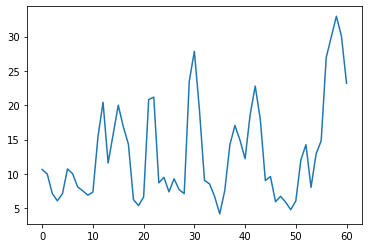

In [157]:
plt.plot(TCprecip_ts[0]['tot_Prec_max'])
plt.show()

In [61]:
! cat /work/FAC/FGSE/IDYST/tbeucler/default/saranya/causal/create_ts/outputs/targets/2003

,tot_Prec_max,tot_Prec_Intg
0,6.3610076904296875,1577.4302184581757
1,20.780086517333984,1702.134683728218
2,14.372825622558594,1724.2608964443207
3,10.556221008300781,1914.949119091034
4,13.16070556640625,1986.5554571151733
5,24.271011352539062,1888.665109872818
6,12.618064880371094,1716.6440188884735
7,7.653236389160156,1609.814167022705
8,8.746147155761719,1393.8189297914505
9,9.99307632446289,1267.9294496774673
10,8.031368255615234,1210.191696882248
11,6.5364837646484375,1091.2500321865082
12,7.77435302734375,1223.4030663967133
13,9.495735168457031,1274.510771036148
14,11.763572692871094,1362.573802471161
15,11.403560638427734,1464.7779613733292
16,11.722087860107422,1314.0477240085602
17,10.392189025878906,1296.6716289520264
18,18.886566162109375,1328.0262053012848
19,21.816253662109375,1404.8673212528229
20,19.504547119140625,1129.8633366823196
21,23.209571838378906,1218.847781419754
22,18.520355224609375,1324.5755434036255
23,20.724773406982422,1353.7552207708359
24,19.282341003

In [158]:
storeTCdicts = {}
for ind in range(len(TCprecip_ts)):
    storeTCdicts[stormname[ind]] = pd.DataFrame.from_dict(TCprecip_ts[ind])

In [159]:
for ind,obj in enumerate(stormname):
    storeTCdicts[obj].to_csv(target+'2010_precipvar_wpac_'+str(obj)+'.csv')

In [ ]:
#burevi 2668:2715
#nivar 2668:2715


In [6]:
track.time

0     2021-09-24:06:00:00
1     2021-09-24:09:00:00
2     2021-09-24:12:00:00
3     2021-09-24:15:00:00
4     2021-09-24:18:00:00
             ...         
76    2021-10-03:18:00:00
77    2021-10-03:21:00:00
78    2021-10-04:00:00:00
79    2021-10-04:03:00:00
80    2021-10-04:06:00:00
Name: time, Length: 81, dtype: object

In [18]:
ds0.time[2130:2211]

<xarray.DataArray 'time' (time: 81)>
array(['2021-09-24T06:00:00.000000000', '2021-09-24T09:00:00.000000000',
       '2021-09-24T12:00:00.000000000', '2021-09-24T15:00:00.000000000',
       '2021-09-24T18:00:00.000000000', '2021-09-24T21:00:00.000000000',
       '2021-09-25T00:00:00.000000000', '2021-09-25T03:00:00.000000000',
       '2021-09-25T06:00:00.000000000', '2021-09-25T09:00:00.000000000',
       '2021-09-25T12:00:00.000000000', '2021-09-25T15:00:00.000000000',
       '2021-09-25T18:00:00.000000000', '2021-09-25T21:00:00.000000000',
       '2021-09-26T00:00:00.000000000', '2021-09-26T03:00:00.000000000',
       '2021-09-26T06:00:00.000000000', '2021-09-26T09:00:00.000000000',
       '2021-09-26T12:00:00.000000000', '2021-09-26T15:00:00.000000000',
       '2021-09-26T18:00:00.000000000', '2021-09-26T21:00:00.000000000',
       '2021-09-27T00:00:00.000000000', '2021-09-27T03:00:00.000000000',
       '2021-09-27T06:00:00.000000000', '2021-09-27T09:00:00.000000000',
       '2021-09-27T12:00:00.000000000', '2021-09-27T15:00:00.000000000',
       '2021-09-27T18:00:00.000000000', '2021-09-27T21:00:00.000000000',
       '2021-09-28T00:00:00.000000000', '2021-09-28T03:00:00.000000000',
       '2021-09-28T06:00:00.000000000', '2021-09-28T09:00:00.000000000',
       '2021-09-28T12:00:00.000000000', '2021-09-28T15:00:00.000000000',
       '2021-09-28T18:00:00.000000000', '2021-09-28T21:00:00.000000000',
       '2021-09-29T00:00:00.000000000', '2021-09-29T03:00:00.000000000',
       '2021-09-29T06:00:00.000000000', '2021-09-29T09:00:00.000000000',
       '2021-09-29T12:00:00.000000000', '2021-09-29T15:00:00.000000000',
       '2021-09-29T18:00:00.000000000', '2021-09-29T21:00:00.000000000',
       '2021-09-30T00:00:00.000000000', '2021-09-30T03:00:00.000000000',
       '2021-09-30T06:00:00.000000000', '2021-09-30T09:00:00.000000000',
       '2021-09-30T12:00:00.000000000', '2021-09-30T15:00:00.000000000',
       '2021-09-30T18:00:00.000000000', '2021-09-30T21:00:00.000000000',
       '2021-10-01T00:00:00.000000000', '2021-10-01T03:00:00.000000000',
       '2021-10-01T06:00:00.000000000', '2021-10-01T09:00:00.000000000',
       '2021-10-01T12:00:00.000000000', '2021-10-01T15:00:00.000000000',
       '2021-10-01T18:00:00.000000000', '2021-10-01T21:00:00.000000000',
       '2021-10-02T00:00:00.000000000', '2021-10-02T03:00:00.000000000',
       '2021-10-02T06:00:00.000000000', '2021-10-02T09:00:00.000000000',
       '2021-10-02T12:00:00.000000000', '2021-10-02T15:00:00.000000000',
       '2021-10-02T18:00:00.000000000', '2021-10-02T21:00:00.000000000',
       '2021-10-03T00:00:00.000000000', '2021-10-03T03:00:00.000000000',
       '2021-10-03T06:00:00.000000000', '2021-10-03T09:00:00.000000000',
       '2021-10-03T12:00:00.000000000', '2021-10-03T15:00:00.000000000',
       '2021-10-03T18:00:00.000000000', '2021-10-03T21:00:00.000000000',
       '2021-10-04T00:00:00.000000000', '2021-10-04T03:00:00.000000000',
       '2021-10-04T06:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2021-09-24T06:00:00 ... 2021-10-04T06:00:00
Attributes:
    standard_name:  time
    axis:           T

In [19]:
#for North Atlantic and East Pacific
lonx=np.mod(lon1,360)
pos = arr = np.stack((lat1, lonx), axis=1)
pos.shape

(81, 2)

In [20]:
pos

array([[18.65  , 92.1   ],
       [18.5112, 91.4885],
       [18.4   , 90.95  ],
       [18.3357, 90.5349],
       [18.2839, 90.2079],
       [18.2325, 89.9368],
       [18.2059, 89.7153],
       [18.2083, 89.5188],
       [18.2228, 89.2971],
       [18.2423, 89.0211],
       [18.2643, 88.73  ],
       [18.2796, 88.4774],
       [18.295 , 88.1811],
       [18.3118, 87.8073],
       [18.3333, 87.3   ],
       [18.3678, 86.5945],
       [18.3921, 85.8415],
       [18.3987, 85.2149],
       [18.3807, 84.6064],
       [18.2813, 84.0022],
       [18.1667, 83.4111],
       [18.1278, 82.796 ],
       [18.1742, 82.1934],
       [18.2232, 81.6372],
       [18.3564, 81.1005],
       [18.6329, 80.5624],
       [18.9387, 80.02  ],
       [19.1426, 79.4624],
       [19.3132, 78.901 ],
       [19.4954, 78.3302],
       [19.6718, 77.7926],
       [19.8358, 77.3193],
       [20.0068, 76.8943],
       [20.1947, 76.5171],
       [20.4101, 76.1059],
       [20.6508, 75.5736],
       [20.9236, 74.9772],
 

In [28]:
tc_irad=np.empty((len(pos),4))
tc_irad[:,0] = pos[:,0]-5
tc_irad[:,1] = pos[:,0]+5
tc_irad[:,2] = pos[:,1]-5
tc_irad[:,3] = pos[:,1]+5

In [22]:
dm0=xr.open_dataset(datapath+'/slev_vars/svars_2021.nc')

In [23]:
dm0=xr.open_dataset(datapath+'/slev_vars/svars_2021.nc')
cld_ice=dm0.var79[2130:2211]
cld_liq=dm0.var78[2130:2211]
cloud=cld_ice+cld_liq

precip=ds0.var228[2130:2211]

In [24]:
precip=ds0.var228[2130:2211]

In [29]:
tc_irad

array([[13.65  , 23.65  , 87.1   , 97.1   ],
       [13.5112, 23.5112, 86.4885, 96.4885],
       [13.4   , 23.4   , 85.95  , 95.95  ],
       [13.3357, 23.3357, 85.5349, 95.5349],
       [13.2839, 23.2839, 85.2079, 95.2079],
       [13.2325, 23.2325, 84.9368, 94.9368],
       [13.2059, 23.2059, 84.7153, 94.7153],
       [13.2083, 23.2083, 84.5188, 94.5188],
       [13.2228, 23.2228, 84.2971, 94.2971],
       [13.2423, 23.2423, 84.0211, 94.0211],
       [13.2643, 23.2643, 83.73  , 93.73  ],
       [13.2796, 23.2796, 83.4774, 93.4774],
       [13.295 , 23.295 , 83.1811, 93.1811],
       [13.3118, 23.3118, 82.8073, 92.8073],
       [13.3333, 23.3333, 82.3   , 92.3   ],
       [13.3678, 23.3678, 81.5945, 91.5945],
       [13.3921, 23.3921, 80.8415, 90.8415],
       [13.3987, 23.3987, 80.2149, 90.2149],
       [13.3807, 23.3807, 79.6064, 89.6064],
       [13.2813, 23.2813, 79.0022, 89.0022],
       [13.1667, 23.1667, 78.4111, 88.4111],
       [13.1278, 23.1278, 77.796 , 87.796 ],
       [13

In [30]:
cloud=cld_ice+cld_liq
precip_nan=precip.where(precip>0, other='nan')
ppr=np.zeros((pos.shape[0],40,40))
pp=np.zeros((tc_irad.shape[0],))
ppm=np.zeros((tc_irad.shape[0],))
ppmaskcloud = np.zeros((pos.shape[0],40,40))

for it in range(tc_irad.shape[0]):
    latn, lats, lone, lonw = tc_irad[it,:]
    ppr[it,:,:]=precip[it,:,:].sel(lat=slice(lats,latn),lon=slice(lone,lonw))[0:40,0:40]
    ppmaskcloud[it,:,:]=cloud[it,:,:].sel(lat=slice(lats,latn),lon=slice(lone,lonw))[0:40,0:40]
    ppm[it]=np.nanmax(ppr[it,:,:])

In [33]:
def preproc_integration(array_precip=None,array_cloud=None,cloudmaskvalue=None):
    pprm = array_precip.copy().flatten()
    pprm[array_cloud.copy().flatten()<cloudmaskvalue] = 0
    return pprm.reshape(array_precip.shape)

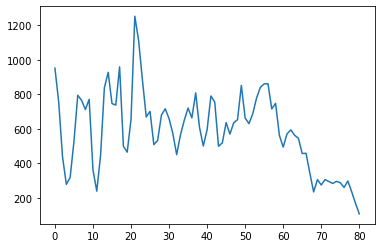

In [34]:
def preproc_integration(array_precip=None,array_cloud=None,cloudmaskvalue=None):
    pprm = array_precip.copy().flatten()
    pprm[array_cloud.copy().flatten()<cloudmaskvalue] = 0
    return pprm.reshape(array_precip.shape)

cloudmaskvalue = np.nanpercentile(ppmaskcloud[...].flatten(),10)
masked_precip = [preproc_integration(ppr[i,...],ppmaskcloud[i,...],cloudmaskvalue) for i in range(ppr.shape[0])]
p=(np.trapz(np.trapz(np.asarray(masked_precip),dx=25,axis=1),dx=25,axis=1))
plt.plot(np.trapz(np.trapz(np.asarray(masked_precip),dx=25,axis=1),dx=25,axis=1))
plt.show()

In [35]:
ppm=ppm*1000 #to convert to mm/hr

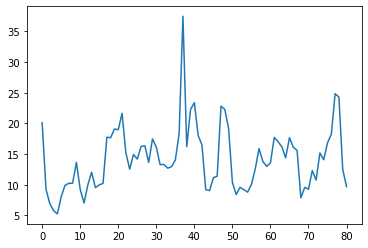

In [36]:
plt.plot(ppm)
plt.show()

In [37]:
p.shape

(81,)

In [38]:
df2 = pd.DataFrame(data=ppm, columns=["tot_Prec_max"])
df3 = pd.DataFrame(data=p, columns=["tot_Prec_Intg"])

In [39]:
df2.to_csv(target+'2021_tot_ppt_max_nio_shahgulab.csv')
df3.to_csv(target+'2021_tot_ppt_int_nio_shahgulab.csv')